## GENERACIÓN DE ZOOM Y MASCARA SOBRE IMAGENES .FITS

In [ ]:
# Instalación de librerías ASTROPY

!pip install astroquery
!pip install astropy opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 34.4 MB/s eta 0:00:00


In [ ]:
# Librerías necesarias
from astroquery.skyview import SkyView
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np
import cv2

In [ ]:
# Importar archivo
ruta_fits = "/content/dataset.fits"
with fits.open(ruta_fits) as hdul:
    data = hdul[1].data
    # Convertir a una lista de diccionarios para evitar problemas de endianess
    rows = [dict(zip(data.names, row)) for row in data]
    df = pd.DataFrame(rows)

In [ ]:
# Verificar nombres de columnas (OBJRA y OBJDEC)
print(df.columns)

Index(['name', 'objra', 'objdec', 'Bars'], dtype='object')


In [ ]:
# Seleccionar 10 registros aleatorios
df_sample = df.sample(n=10, random_state=42)

# Mostrar coordenadas seleccionadas
print(df_sample[['objra', 'objdec']].head())

           objra     objdec
3781  262.074922  56.774780
2922  138.380706  28.951757
5070  237.451396  38.002924
7246  131.793177  53.830608
623   143.968854   4.016812


In [ ]:
# Crear carpeta de salida (en caso de querer guardar archivos)
output_dir = "/content/Salida_imagenes"
os.makedirs(output_dir, exist_ok=True)

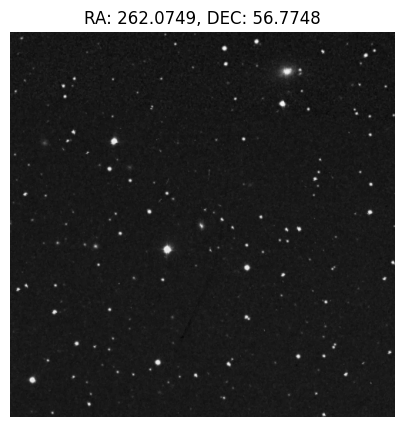

✅ Imagen guardada: /content/Salida_imagenes/galaxy_3781_ra262.0749_dec56.7748.fits


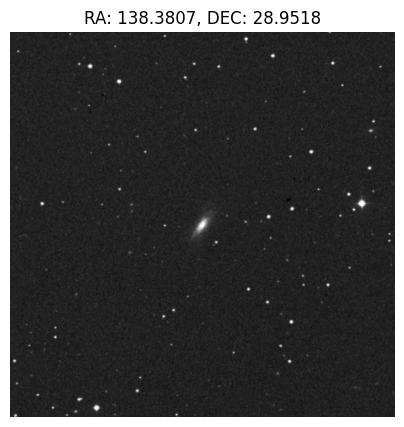

✅ Imagen guardada: /content/Salida_imagenes/galaxy_2922_ra138.3807_dec28.9518.fits


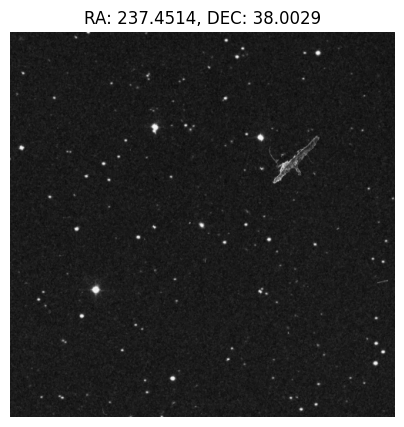

✅ Imagen guardada: /content/Salida_imagenes/galaxy_5070_ra237.4514_dec38.0029.fits


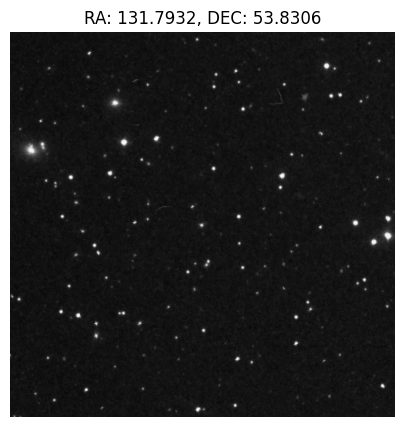

✅ Imagen guardada: /content/Salida_imagenes/galaxy_7246_ra131.7932_dec53.8306.fits


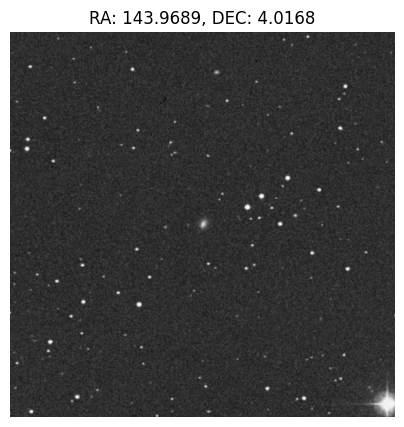

✅ Imagen guardada: /content/Salida_imagenes/galaxy_623_ra143.9689_dec4.0168.fits


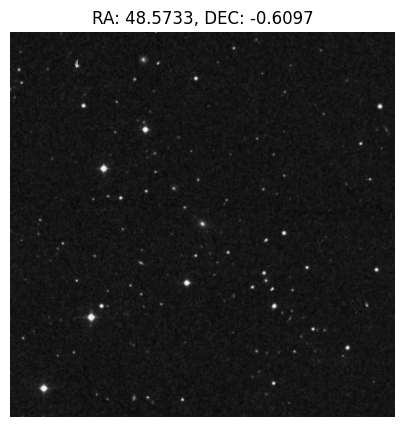

✅ Imagen guardada: /content/Salida_imagenes/galaxy_3931_ra48.5733_dec-0.6097.fits


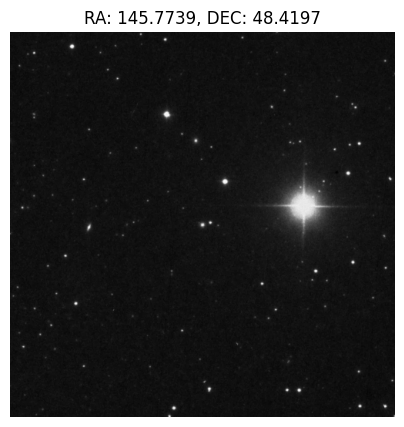

✅ Imagen guardada: /content/Salida_imagenes/galaxy_4767_ra145.7739_dec48.4197.fits


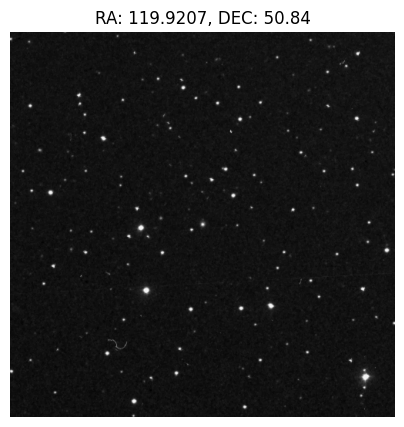

✅ Imagen guardada: /content/Salida_imagenes/galaxy_7094_ra119.9207_dec50.84.fits


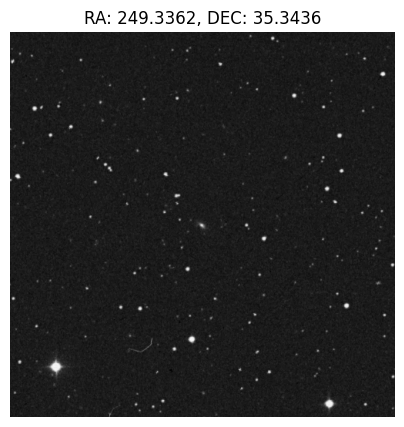

✅ Imagen guardada: /content/Salida_imagenes/galaxy_3282_ra249.3362_dec35.3436.fits


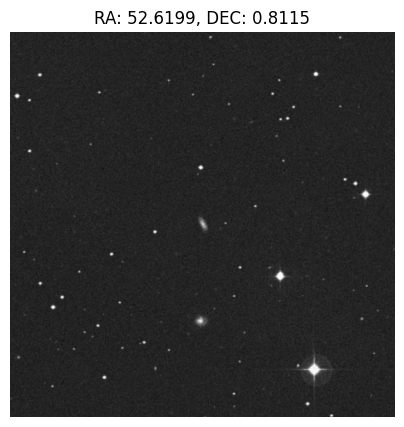

✅ Imagen guardada: /content/Salida_imagenes/galaxy_3994_ra52.6199_dec0.8115.fits


In [ ]:
# Iterar sobre coordenadas seleccionadas
for index, row in df_sample.iterrows():
    ra = row['objra']
    dec = row['objdec']
    position = f"{ra} {dec}"

    try:
        # Obtener imagen del survey DSS (Digital Sky Survey)
        images = SkyView.get_images(position=position, survey='DSS', pixels=500)

        # Extraer datos FITS
        hdu = images[0][0]
        image_data = hdu.data

        # Mostrar la imagen en notebook
        plt.figure(figsize=(5, 5))
        plt.imshow(image_data, cmap='gray', origin='lower')
        plt.title(f"RA: {round(ra, 4)}, DEC: {round(dec, 4)}")
        plt.axis('off')
        plt.show()

        # Guardar como archivo .fits
        fits_path = os.path.join(output_dir, f"galaxy_{index}_ra{round(ra, 4)}_dec{round(dec, 4)}.fits")
        hdu.writeto(fits_path, overwrite=True)
        print(f"Imagen guardada: {fits_path}")

    except Exception as e:
        print(f"Error al descargar imagen para RA={ra}, DEC={dec}: {e}")

In [ ]:
# Cargar imagen FITS
ruta = "/content/Salida_imagenes/galaxy_3282_ra249.3362_dec35.3436.fits"  # cambia por la ruta de tu archivo
hdu = fits.open(ruta)[0]
img = hdu.data

In [ ]:
# Función para aplicar zoom centrado
def aplicar_zoom(img, zoom_factor=2.0):                           # recibe una imagen, con zoom 2 por defecto
    h, w = img.shape                                              # Extrae (h) altura y (w) ancho
    cx, cy = w // 2, h // 2                                       # Cálcula las coordenadas al centro cx=horizontal cy=vertical
    crop_w, crop_h = int(w / zoom_factor), int(h / zoom_factor)   # Cálcula el recorte con base en el facto de entrada
    x1, y1 = cx - crop_w // 2, cy - crop_h // 2                   # Esquina superior izquierda
    x2, y2 = cx + crop_w // 2, cy + crop_h // 2                   # Esquina inferior derecha
    zoomed = img[y1:y2, x1:x2]                                    # Imagén centrada
    return zoomed

In [ ]:
# Función para aplicar una máscara a la imagén
def aplicar_mascara_circular(img, porcentaje_radio=0.4):
    h, w = img.shape
    center = (w // 2, h // 2)
    radius = int(min(w, h) * porcentaje_radio)

    # Crear máscara flotante con valores entre 0 y 1
    y, x = np.ogrid[:h, :w]
    distancia = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = (distancia <= radius).astype(float)

    # Aplicar la máscara conservando el contraste original
    result = img * mask

    return result

In [ ]:
# Ejecutar funciones de zoom y máscara
img_zoom = aplicar_zoom(img, zoom_factor=5.0)   # Definición de factor de zoom
img_masked = aplicar_mascara_circular(img_zoom)

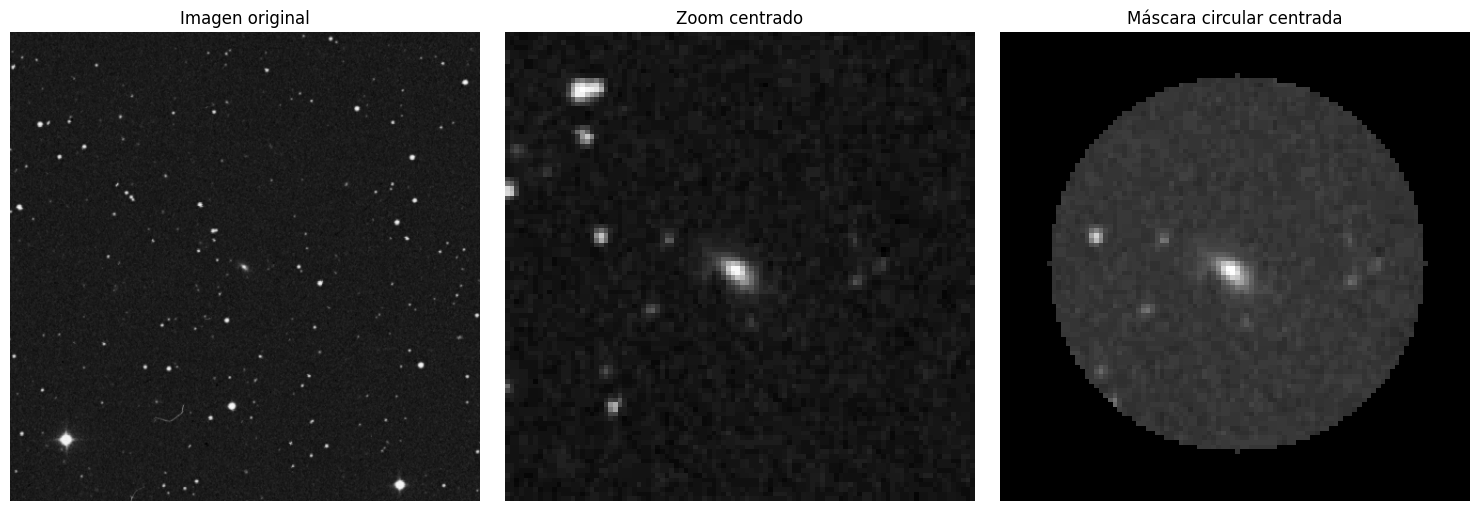

In [ ]:
# Mostrar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', origin='lower')
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_zoom, cmap='gray', origin='lower')
plt.title("Zoom centrado")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_masked, cmap='gray', origin='lower')
plt.title("Máscara circular centrada")
plt.axis('off')

plt.tight_layout()
plt.show()